In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
tf.__version__

'2.4.0-dev20200802'

In [10]:
list(data_dir.glob("*.png"))

[PosixPath('captcha_images_v2/mmg2m.png'),
 PosixPath('captcha_images_v2/nfndw.png'),
 PosixPath('captcha_images_v2/gw53m.png'),
 PosixPath('captcha_images_v2/yw667.png'),
 PosixPath('captcha_images_v2/n4xx5.png'),
 PosixPath('captcha_images_v2/gng6e.png'),
 PosixPath('captcha_images_v2/2pfpn.png'),
 PosixPath('captcha_images_v2/5xd2e.png'),
 PosixPath('captcha_images_v2/3nnpw.png'),
 PosixPath('captcha_images_v2/en32e.png'),
 PosixPath('captcha_images_v2/6g45w.png'),
 PosixPath('captcha_images_v2/nybcx.png'),
 PosixPath('captcha_images_v2/mcg43.png'),
 PosixPath('captcha_images_v2/2wx73.png'),
 PosixPath('captcha_images_v2/58pnp.png'),
 PosixPath('captcha_images_v2/84w7x.png'),
 PosixPath('captcha_images_v2/fcmem.png'),
 PosixPath('captcha_images_v2/4w76g.png'),
 PosixPath('captcha_images_v2/2p2y8.png'),
 PosixPath('captcha_images_v2/nfg23.png'),
 PosixPath('captcha_images_v2/xce8d.png'),
 PosixPath('captcha_images_v2/b4ncn.png'),
 PosixPath('captcha_images_v2/mc8w2.png'),
 PosixPath(

In [11]:
# Path to the data directory
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png"))))) #data_dir.glob outputs posixpath (ref above) mapped to str
print(images[:33])

labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
print(labels[:33])

characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print("Max Length within labels ",max_length)

['captcha_images_v2/226md.png', 'captcha_images_v2/22d5n.png', 'captcha_images_v2/2356g.png', 'captcha_images_v2/23mdg.png', 'captcha_images_v2/23n88.png', 'captcha_images_v2/243mm.png', 'captcha_images_v2/244e2.png', 'captcha_images_v2/245y5.png', 'captcha_images_v2/24f6w.png', 'captcha_images_v2/24pew.png', 'captcha_images_v2/25257.png', 'captcha_images_v2/253dc.png', 'captcha_images_v2/25egp.png', 'captcha_images_v2/25m6p.png', 'captcha_images_v2/25p2m.png', 'captcha_images_v2/25w53.png', 'captcha_images_v2/264m5.png', 'captcha_images_v2/268g2.png', 'captcha_images_v2/28348.png', 'captcha_images_v2/28x47.png', 'captcha_images_v2/2b827.png', 'captcha_images_v2/2bg48.png', 'captcha_images_v2/2cegf.png', 'captcha_images_v2/2cg58.png', 'captcha_images_v2/2cgyx.png', 'captcha_images_v2/2en7g.png', 'captcha_images_v2/2enf4.png', 'captcha_images_v2/2fxgd.png', 'captcha_images_v2/2g783.png', 'captcha_images_v2/2g7nm.png', 'captcha_images_v2/2gyb6.png', 'captcha_images_v2/2mg87.png', 'captch

In [12]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'2', 'g', '5', 'm', '4', 'n', 'c', '3', 'd', 'w', 'p', '6', 'b', 'x', 'y', '7', '8', 'e', 'f'}


In [13]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

##Create Dataset Objects

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
#encoding each image sample with map function
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [15]:
train_dataset.take(1)

<TakeDataset shapes: {image: (None, 200, 50, 1), label: (None, None)}, types: {image: tf.float32, label: tf.int64}>

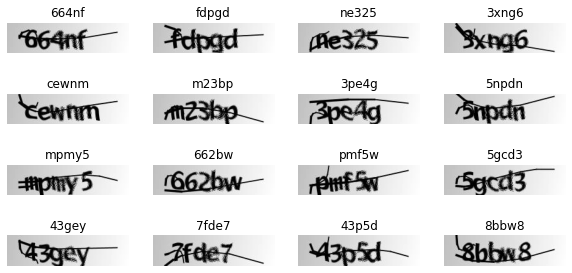

In [16]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1): #one batch of samples (here, 16)
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [17]:
class CTCLayer(layers.Layer):  # inheriting as subclass of the keras layers class
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):  # call is the default method to invoke on call to the layer
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(   # layers is from tensorflow.keras
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    
    new_shape = ((img_width // 4), (img_height // 4) * 64)  # dimension of feature map from CNN reduced accross the width
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x) # +1 in output nodes is for the blank character used in CTC Loss

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [18]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 [==============================] - 27s 457ms/step - loss: 30.1663 - val_loss: 16.3334
Epoch 2/100
59/59 [==============================] - 14s 229ms/step - loss: 16.3626 - val_loss: 16.3091
Epoch 3/100
59/59 [==============================] - 12s 206ms/step - loss: 16.3605 - val_loss: 16.3130
Epoch 4/100
59/59 [==============================] - 12s 210ms/step - loss: 16.3611 - val_loss: 16.3101
Epoch 5/100
59/59 [==============================] - 12s 206ms/step - loss: 16.3503 - val_loss: 16.3039
Epoch 6/100
59/59 [==============================] - 12s 207ms/step - loss: 16.3368 - val_loss: 16.2912
Epoch 7/100
59/59 [==============================] - 12s 209ms/step - loss: 16.2877 - val_loss: 16.1135
Epoch 8/100
59/59 [==============================] - 12s 208ms/step - loss: 16.0312 - val_loss: 15.6210
Epoch 9/100
59/59 [==============================] - 12s 212ms/step - loss: 15.4914 - val_loss: 14.6615
Epoch 10/100
59/59 [==============================] - 13s 216ms/

In [20]:
model.save('captcha_model.h5')

## Inference

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)           

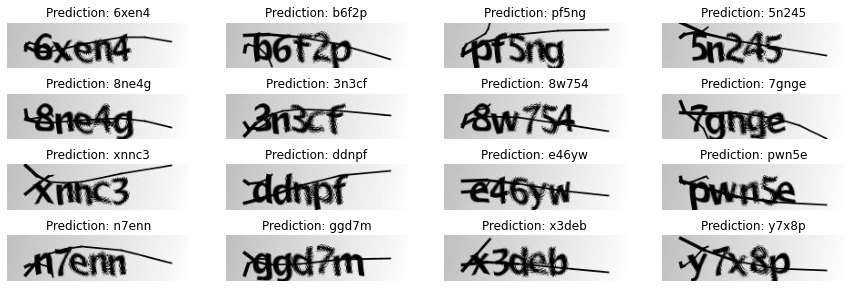

In [19]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    print(pred, pred.shape)
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        print(res)
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        print("Decoded from CTC ",res)
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()